# Workshop Exercise

Let us do some research now, with help of the [CMIP6 dataset](https://pcmdi.llnl.gov/CMIP6/).
I have setup some possible climate change models for you to use, you have to fill in your camel ID and think of a research question!

We like the sentence:
- To understand [environment issue] in [region] we will study te impact of [verb/noun] on [hydrological variable].

But feel free to come up with your own! Maybe look at a smaller time period of 5-10 years.

In [2]:
# Required dependencies
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import ewatercycle
import ewatercycle.models

from util_functions import *

/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


In [3]:
# Copy your camel ID from previous Notebook
camel_id = "AF_1491830.0"

In [4]:
# Defining path for catchment shape file
central_path = "/data/datasets/zimbabwe/camel_data"

path_to_save = Path.home() / "my_data/workshop_zimbabwe"
path_to_save.mkdir(exist_ok=True, parents=True)

shape_file = central_path + "/shapefiles" + f"/{str(camel_id[:-2])}" + f"/{str(camel_id[:-2])}.shp"
data_file_nc = central_path + (f"/{camel_id}.nc")

my_data_nc = xr.open_dataset(data_file_nc, engine="netcdf4")

# Defining destination path for CMIP data
forcing_path_CMIP = path_to_save / "CMIP_forcing"
forcing_path_CMIP.mkdir(exist_ok=True)

# Model HBV destination path
model_path_HBV = path_to_save / "CMIP_HBV"
model_path_HBV.mkdir(exist_ok=True)

In [5]:
future_start_data = "2026-01-01"
future_end_data = "2099-12-31"

## Downloading the climate scenarios
CMIP datasets can be found [here](https://aims2.llnl.gov/nodes), sometimes their servers are unreachable.
CMIP has these climate scenarios based on carbon emmisions, go [here](https://climate-scenarios.canada.ca/?page=cmip6-overview-notes) (or [here](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios)) to find out more!
Here I setup SSP1, 2 and 5:

- **SSP1**: The sustainable and “green” pathway describes an increasingly sustainable world. Global commons are being preserved, the limits of nature are being respected. The focus is more on human well-being than on economic growth. Income inequalities between states and within states are being reduced. Consumption is oriented towards minimizing material resource and energy usage.

- **SSP2**: The “Middle of the road” or medium pathway extrapolates the past and current global development into the future. Income trends in different countries are diverging significantly. There is a certain cooperation between states, but it is barely expanded. Global population growth is moderate, leveling off in the second half of the century. Environmental systems are facing a certain degradation.

- **SSP3**: Regional rivalry. A revival of nationalism and regional conflicts pushes global issues into the background. Policies increasingly focus on questions of national and regional security. Investments in education and technological development are decreasing. Inequality is rising. Some regions suffer drastic environmental damage.

- **SSP4**: Inequality. The chasm between globally cooperating developed societies and those stalling at a lower developmental stage with low income and a low level of education is widening. Environmental policies are successful in tackling local problems in some regions, but not in others.

- **SSP5**: Fossil-fueled Development. Global markets are increasingly integrated, leading to innovations and technological progress. The social and economic development, however, is based on an intensified exploitation of fossil fuel resources with a high percentage of coal and an energy-intensive lifestyle worldwide. The world economy is growing and local environmental problems such as air pollution are being tackled successfully.

The numbers behind the SSP1xx mean extra radiative forcing of $x.x$ $W/m^2$ by the year 2100. They come in at $1.9$, $2.6$, $3.4$, $4.5$, $6.0$, $7.0$ and $8.5$ $W/m^2$.

Since we are saving it to their respective folder (so if you change them, keep track of the folders) we only have to run the data gathering **ONCE**.

In [5]:
# We will need to generate CMIP data and save it, to use it later.
# ONLY RUN THIS ONCE
# DO this for every experiment you want to do!

# Generate SSP126 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp126',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_start_data+"T00:00:00Z",
   end_time=future_end_data+"T00:00:00Z",
   shape=shape_file,
   directory=forcing_path_CMIP / "SSP126",
)

# Generate SSP245 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp245',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_start_data+"T00:00:00Z",
   end_time=future_end_data+"T00:00:00Z",
   shape=shape_file,
   directory=forcing_path_CMIP / "SSP245",
)

# Generate SSP585 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp585',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_start_data+"T00:00:00Z",
   end_time=future_end_data+"T00:00:00Z",
   shape=shape_file,
   directory=forcing_path_CMIP / "SSP585",
)

In [6]:
# Load the generated SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load the generated SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load the generated SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

In [7]:
# Add your parameters here, dont change the FM below, keep it at 0.001
parameters_found = [
    10.0,   # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.1,    # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001   # FM - Snowmelt factor (not critical in Zimbabwe, can remain low)
]

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

## Setting up the models

I took this bit from our Bachelor student Ischa, so thank you very much!
We put the forcings in a list and then we will use that to look through the models we created, using the BMI implementation.

In [8]:
forcing_list = [SSP126, SSP245, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(
        parameters=parameters_found, 
        initial_storage=s_0,
        cfg_dir = model_path_HBV,
    )

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

## Checking our results
Finally, we look at the output and we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [9]:
SSP126_output = pd.Series(data=output[0], name="SSP126", index=years[0])
SSP245_output = pd.Series(data=output[1], name="SSP245", index=years[1])
SSP585_output = pd.Series(data=output[2], name="SSP585", index=years[2])

print(SSP126_output)

2026-01-02 12:00:00    0.050504
2026-01-03 12:00:00    0.050501
2026-01-04 12:00:00    0.050498
2026-01-05 12:00:00    0.050488
2026-01-06 12:00:00    0.050473
                         ...   
2099-12-27 12:00:00    2.421937
2099-12-28 12:00:00    2.371266
2099-12-29 12:00:00    2.302091
2099-12-30 12:00:00    2.095406
2099-12-31 12:00:00    1.900903
Name: SSP126, Length: 27027, dtype: float64

Now for the visualising you will look at the model outputs, which is, as you will see, pointless for this many years.

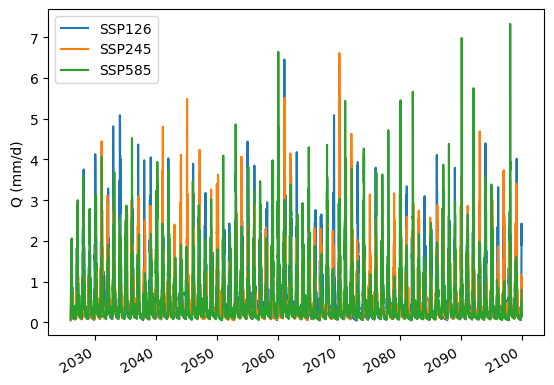

In [10]:
SSP126_output.plot()
SSP245_output.plot()
SSP585_output.plot()
plt.ylabel("Q (mm/d)")
plt.legend()

## Enter your research here!
I looked at the cumulative sum of the discharge as a simle example, up to you to implement your own!

In [11]:
cum_sum_126 = np.cumsum(SSP126_output)
cum_sum_245 = np.cumsum(SSP245_output)
cum_sum_585 = np.cumsum(SSP585_output)

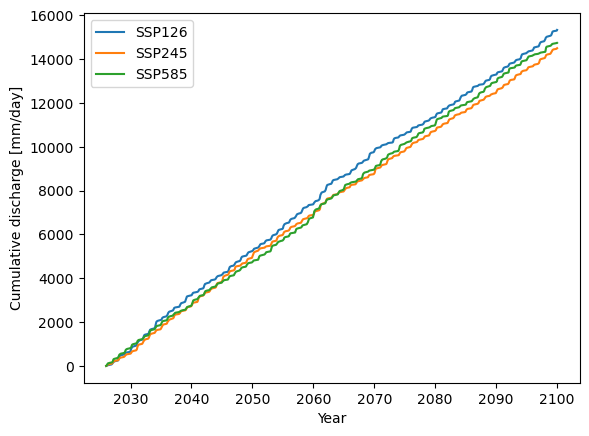

In [13]:
plt.plot(cum_sum_126, label="SSP126")
plt.plot(cum_sum_245, label="SSP245")
plt.plot(cum_sum_585, label="SSP585")
plt.ylabel("Cumulative discharge [mm/day]")
plt.xlabel("Year")
plt.legend()
plt.show()